<a href="https://colab.research.google.com/github/gussarantes/IA025A-2022S1/blob/main/aula03/Exerc%C3%ADcio_de_sala_Aula_03_Gustavo_Arantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Gustavo da Silva Arantes

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

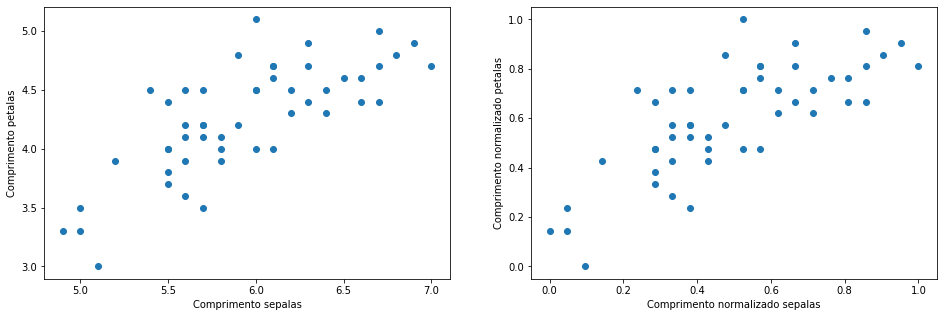

In [3]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [4]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np
import torch
from torch import nn, optim

random.seed(123)
np.random.seed(123)

In [5]:
class Model():
    def __init__(self, n_in: int, n_out: int):
        # Escreva seu código aqui.
        # Não se esqueça de inicializar os pesos da rede com zeros.
        self.w = np.zeros((n_out, n_in))
    
    def forward(self, x):
        # Escreva seu código aqui.
        y_pred = x.dot(self.w.T)
        return y_pred

In [6]:
def train(model, x, y, learning_rate: float, n_epochs: int):
    """Train a linear model with SGD.

    Returns:
        loss_history: a np.array of shape (n_epochs,)
        w_history: a np.array of shape (n_epochs, 2)
    """
    # Escreva seu código aqui.
    loss_history = []
    w_history = np.empty((0,2), np.float32)
    n_samples = x.shape[0]
    x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x])

    for epoch in range(n_epochs+1):

      # weights
      w_history = np.append(w_history, model.w, axis=0)

      # predict
      y_pred = model.forward(x_train_bias)

      # loss
      loss = np.square(y_pred - y).mean()
      loss_history.append(loss)

      # gradient
      w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y)
      # print(type(w_grad))
      # print(w_grad.shape)
      # print(w_grad.T)
      
      # atualização dos pesos
      model.w = model.w - learning_rate * w_grad.T

      # verbose
      print('Epoch[{}/{}], loss: {:.6f}, pesos: {}'.format(epoch, n_epochs, loss, model.w))
    return loss_history, w_history

In [7]:
## treinamento via torch.nn e MSE

model = torch.nn.Linear(in_features=2, out_features=1, bias=False)
model.weight.data = torch.zeros(1,2)

x_tensor = torch.FloatTensor(x)
y_tensor = torch.FloatTensor(y)

n_samples = x_tensor.shape[0]
x_train_bias = torch.cat([torch.ones(size=(n_samples,1)), x_tensor],dim=1)
x_train_bias

criterion = nn.MSELoss() # função de custo
optimizer = optim.SGD(model.parameters(), lr=0.5) # model parameters fala q vai atualizar TODOS parametros da rede


torch_loss_history = []
torch_w_history = np.empty((0,2), np.float32)
n_epochs = 20
for epoch in range(n_epochs+1):
    inputs = x_train_bias
    target = y_tensor

    # weights
    torch_w_history = np.append(torch_w_history, model.weight.data, axis=0)

    # forward - predict
    out = model(inputs)

    #loss cálculo da função de perda
    loss = criterion(out, target) # função de custo definida MSE
    torch_loss_history.append(loss.item())
    
    # backward e otimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # otimizador escolhido SGD
    
    # verbose
    print('Epoch[{}/{}], loss: {:.6f}, pesos: {}'.format(epoch, n_epochs, loss, model.weight.data))

Epoch[0/20], loss: 0.409070, pesos: tensor([[0.6000, 0.3366]])
Epoch[1/20], loss: 0.055997, pesos: tensor([[0.4339, 0.2754]])
Epoch[2/20], loss: 0.032085, pesos: tensor([[0.4641, 0.3147]])
Epoch[3/20], loss: 0.029729, pesos: tensor([[0.4448, 0.3271]])
Epoch[4/20], loss: 0.028853, pesos: tensor([[0.4386, 0.3454]])
Epoch[5/20], loss: 0.028139, pesos: tensor([[0.4296, 0.3611]])
Epoch[6/20], loss: 0.027497, pesos: tensor([[0.4218, 0.3766]])
Epoch[7/20], loss: 0.026914, pesos: tensor([[0.4142, 0.3911]])
Epoch[8/20], loss: 0.026385, pesos: tensor([[0.4070, 0.4051]])
Epoch[9/20], loss: 0.025905, pesos: tensor([[0.4002, 0.4183]])
Epoch[10/20], loss: 0.025469, pesos: tensor([[0.3936, 0.4310]])
Epoch[11/20], loss: 0.025073, pesos: tensor([[0.3874, 0.4430]])
Epoch[12/20], loss: 0.024713, pesos: tensor([[0.3814, 0.4545]])
Epoch[13/20], loss: 0.024387, pesos: tensor([[0.3758, 0.4655]])
Epoch[14/20], loss: 0.024090, pesos: tensor([[0.3704, 0.4759]])
Epoch[15/20], loss: 0.023821, pesos: tensor([[0.36

### Testando as funções

In [8]:
model = Model(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train(model=model, x=x, y=y, learning_rate=0.5, n_epochs=20)

Epoch[0/20], loss: 0.409070, pesos: [[0.6        0.33664399]]
Epoch[1/20], loss: 0.055997, pesos: [[0.4339223  0.27542455]]
Epoch[2/20], loss: 0.032085, pesos: [[0.46412389 0.31466086]]
Epoch[3/20], loss: 0.029729, pesos: [[0.44476731 0.3271254 ]]
Epoch[4/20], loss: 0.028853, pesos: [[0.43861814 0.3453676 ]]
Epoch[5/20], loss: 0.028139, pesos: [[0.42961865 0.36112358]]
Epoch[6/20], loss: 0.027497, pesos: [[0.4218457  0.37655178]]
Epoch[7/20], loss: 0.026914, pesos: [[0.41423446 0.39114629]]
Epoch[8/20], loss: 0.026385, pesos: [[0.4070345 0.4050796]]
Epoch[9/20], loss: 0.025905, pesos: [[0.40016073 0.41834888]]
Epoch[10/20], loss: 0.025469, pesos: [[0.39361455 0.43099414]]
Epoch[11/20], loss: 0.025073, pesos: [[0.38737623 0.44304257]]
Epoch[12/20], loss: 0.024713, pesos: [[0.38143233 0.45452291]]
Epoch[13/20], loss: 0.024387, pesos: [[0.3757687  0.46546178]]
Epoch[14/20], loss: 0.024090, pesos: [[0.37037219 0.47588478]]
Epoch[15/20], loss: 0.023821, pesos: [[0.36523017 0.48581621]]
Epoc

In [9]:
# Assert do histórico de losses
target_loss_history = np.array(
    [0.40907029, 0.0559969 , 0.03208511, 0.02972902, 0.02885257,
     0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
     0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
     0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
     0.0228054])

# target_loss_history = np.zeros(21)

assert np.allclose(loss_history,                 target_loss_history, atol=1e-6)
assert np.allclose(np.array(torch_loss_history), target_loss_history, atol=1e-6)


In [10]:
# Assert de histórico de pesos da rede
target_w_history = np.array(
    [[0.,         0.        ],
    [0.6,        0.336644  ],
    [0.4339223,  0.27542454],
    [0.4641239,  0.31466085],
    [0.44476733, 0.3271254 ],
    [0.43861815, 0.3453676 ],
    [0.42961866, 0.3611236 ],
    [0.4218457,  0.37655178],
    [0.41423446, 0.3911463 ],
    [0.40703452, 0.4050796 ],
    [0.40016073, 0.41834888],
    [0.39361456, 0.43099412],
    [0.38737625, 0.44304258],
    [0.38143232, 0.4545229 ],
    [0.3757687,  0.4654618 ],
    [0.37037218, 0.4758848 ],
    [0.36523017, 0.48581624],
    [0.36033067, 0.49527928],
    [0.35566223, 0.50429606],
    [0.35121396, 0.5128876 ],
    [0.34697545, 0.52107394]])

assert np.allclose(w_history,       target_w_history, atol=1e-6)
assert np.allclose(torch_w_history, target_w_history, atol=1e-6)



In [11]:
## treinamento via torch.nn e BCELoss

model_bce = torch.nn.Linear(in_features=2, out_features=1, bias=False)
model_bce.weight.data = torch.zeros(1,2)

x_tensor_bce = torch.FloatTensor(x)
y_tensor_bce = torch.FloatTensor(y)

n_samples = x_tensor_bce.shape[0]
x_train_bias_bce = torch.cat([torch.ones(size=(n_samples,1)), x_tensor_bce],dim=1)

criterion = nn.BCELoss() # função de custo
optimizer = optim.SGD(model_bce.parameters(), lr=0.5) # model parameters fala q vai atualizar TODOS parametros da rede

torch_loss_history_bce = []
torch_w_history_bce = np.empty((0,2), np.float32)
n_epochs = 20
for epoch in range(n_epochs+1):
    inputs = x_train_bias_bce
    target = y_tensor_bce

    # weights
    torch_w_history_bce = np.append(torch_w_history_bce, model_bce.weight.data, axis=0)

    # forward - predict
    out = model_bce(inputs)
    # print(out)

    #loss cálculo da função de perda
    # loss = criterion(out, target) # função de custo definida BCE
    loss = criterion(torch.sigmoid(out.float()), target.float()) #ajuste inspirado no código da aluna Larissa Santesso
    torch_loss_history_bce.append(loss.item())
    
    # backward e otimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # otimizador escolhido SGD
    
    # verbose
    print('Epoch[{}/{}], loss: {:.6f}, pesos: {}'.format(epoch, n_epochs, loss, model_bce.weight.data))

Epoch[0/20], loss: 0.693147, pesos: tensor([[0.0500, 0.0450]])
Epoch[1/20], loss: 0.684766, pesos: tensor([[0.0910, 0.0852]])
Epoch[2/20], loss: 0.678647, pesos: tensor([[0.1244, 0.1214]])
Epoch[3/20], loss: 0.674135, pesos: tensor([[0.1514, 0.1541]])
Epoch[4/20], loss: 0.670763, pesos: tensor([[0.1731, 0.1840]])
Epoch[5/20], loss: 0.668203, pesos: tensor([[0.1903, 0.2115]])
Epoch[6/20], loss: 0.666221, pesos: tensor([[0.2038, 0.2369]])
Epoch[7/20], loss: 0.664653, pesos: tensor([[0.2141, 0.2606]])
Epoch[8/20], loss: 0.663382, pesos: tensor([[0.2217, 0.2828]])
Epoch[9/20], loss: 0.662324, pesos: tensor([[0.2271, 0.3038]])
Epoch[10/20], loss: 0.661420, pesos: tensor([[0.2306, 0.3237]])
Epoch[11/20], loss: 0.660630, pesos: tensor([[0.2325, 0.3426]])
Epoch[12/20], loss: 0.659921, pesos: tensor([[0.2330, 0.3608]])
Epoch[13/20], loss: 0.659274, pesos: tensor([[0.2325, 0.3783]])
Epoch[14/20], loss: 0.658671, pesos: tensor([[0.2309, 0.3952]])
Epoch[15/20], loss: 0.658103, pesos: tensor([[0.22

# Função de cálculo do grid de custos

In [12]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array with the same shape of w_0_grid (or w_1_grid). 
    """
    # Escreva seu código aqui.
    n_samples = x.shape[0]
    x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x])

    ww0, ww1 = np.meshgrid(w_0_grid, w_1_grid)
    w_grid = np.c_[ww0.ravel(), ww1.ravel()]

    e = x_train_bias.dot(w_grid.T) - y
    loss_grid = (e * e).mean(axis=0)
    loss_grid = loss_grid.reshape(ww0.shape)
    return loss_grid

In [13]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

In [14]:
wmin_bce = torch_w_history_bce.min(axis=0)
wmax_bce = torch_w_history_bce.max(axis=0)
D_bce = wmax_bce - wmin_bce
wmin_bce -= D_bce
wmax_bce += D_bce

w_0_grid_bce = np.linspace(wmin_bce[0], wmax_bce[0], 100)
w_1_grid_bce = np.linspace(wmin_bce[1], wmax_bce[1], 100)

loss_grid_bce = compute_loss_grid(x, y, w_0_grid_bce, w_1_grid_bce)

### Testando a função

In [15]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [16]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6) 

## Funcão de Plot

In [17]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

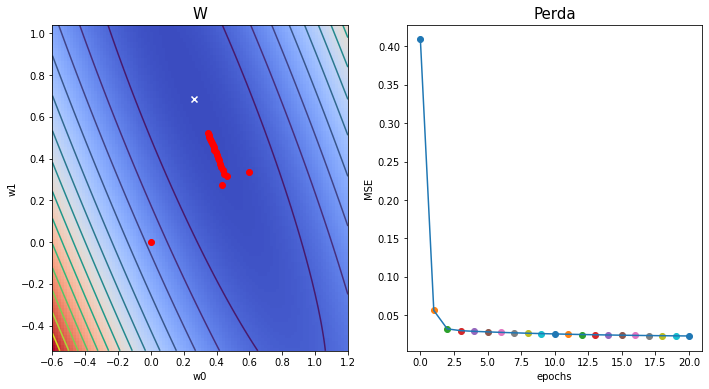

In [18]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass

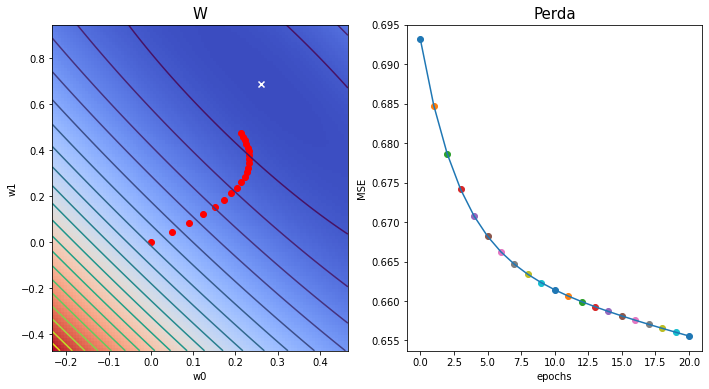

In [19]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid_bce, w_1_grid_bce, loss_grid_bce, np.array(torch_loss_history_bce), torch_w_history_bce, sleep=0.01)
except KeyboardInterrupt:
    pass